In [3]:
import copy
import torch
import numpy as np

def deepfool(image, model, num_classes=10, overshoot=0.02, max_iterations=10):

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    
    # Forward pass to get the network's predictions
    original_predictions = model(image).data.cpu().numpy().flatten()
    
    # Sort the class indices by confidence
    sorted_class_indices = np.argsort(original_predictions)[::-1]
    top_class_indices = sorted_class_indices[0:num_classes]
    original_label = top_class_indices[0]

    input_shape = image.detach().cpu().numpy().shape
    perturbed_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    perturbation = np.zeros(input_shape)

    iterations = 0

    # Create a tensor from the perturbed image and enable gradient computation
    x = torch.tensor(perturbed_image[None, :], requires_grad=True, device=device)
    
    current_predictions = model(x[0])
    current_confidences = [current_predictions[0, top_class_indices[k]] for k in range(num_classes)]
    perturbed_label = original_label

    while perturbed_label == original_label and iterations < max_iterations:

        perturbation_magnitude = np.inf
        
        # Backpropagate gradients from the highest confidence class
        current_predictions[0, top_class_indices[0]].backward(retain_graph=True)
        gradient_original = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            current_predictions[0, top_class_indices[k]].backward(retain_graph=True)
            gradient_current = x.grad.data.cpu().numpy().copy()

            # Calculate the importance of the perturbation
            w_k = gradient_current - gradient_original
            f_k = (current_predictions[0, top_class_indices[k]] - current_predictions[0, top_class_indices[0]]).data.cpu().numpy()

            perturbation_magnitude_k = abs(f_k) / np.linalg.norm(w_k.flatten())

            if perturbation_magnitude_k < perturbation_magnitude:
                perturbation_magnitude = perturbation_magnitude_k
                w = w_k

        # Compute the perturbation for the current iteration
        perturbation_i = (perturbation_magnitude + 1e-4) * w / np.linalg.norm(w)
        perturbation = np.float32(perturbation + perturbation_i)

        perturbed_image = image + (1 + overshoot) * torch.from_numpy(perturbation).to(device)
        x = torch.tensor(perturbed_image, requires_grad=True, device=device)
        current_predictions = model(x[0])
        perturbed_label = np.argmax(current_predictions.data.cpu().numpy().flatten())

        iterations += 1

    perturbation = (1 + overshoot) * perturbation

    return perturbation, iterations, original_label, perturbed_label, perturbed_image


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def display_images_with_labels_and_difference(image1, label1, image2, label2, difference):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Display the first image with its label
    axes[0].imshow(image1.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title(f"Label: {label1}")
    axes[0].axis('off')

    # Display the second image with its label
    axes[1].imshow(image2[0].permute(1, 2, 0).cpu().numpy())  # Remove the batch dimension
    axes[1].set_title(f"Label: {label2}")
    axes[1].axis('off')

    # Display the absolute difference between the two images
    axes[2].imshow(difference)
    axes[2].set_title("Difference")
    axes[2].axis('off')

    plt.show()


C:\Users\josep\AppData\Local\Temp\ipykernel_5764\1273649256.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(perturbed_image[None, :], requires_grad=True, device=device)
C:\Users\josep\AppData\Local\Temp\ipykernel_5764\1273649256.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(perturbed_image, requires_grad=True, device=device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

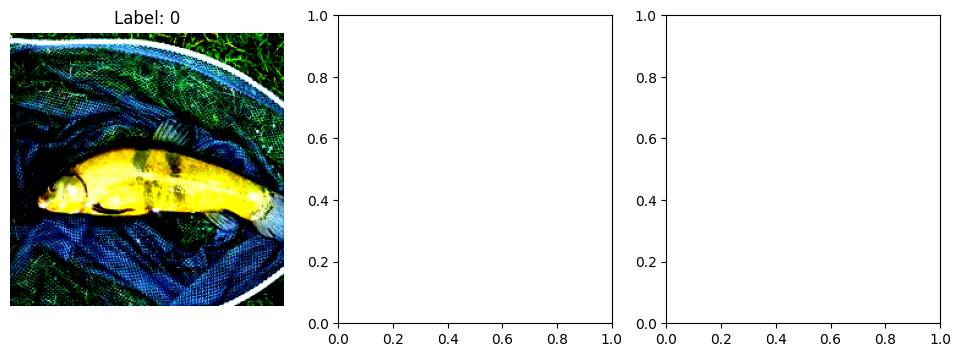

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt

# Load a sample image from ImageNet (you can replace this with your own image)
image_path = 'C:\\Users\\josep\\OneDrive\\Desktop\\ML2_Project\\AdversarialRobustnessML\\DataFiles\\ImageNet\\Original\\imagenette2-320\\train\\n01440764\\ILSVRC2012_val_00007197.JPEG'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = preprocess(image)
image = image.unsqueeze(0)  # Add a batch dimension

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the image to the same device as the model (GPU if available)
image = image.to(device)

# Load a pretrained CaffeNet model (you can replace this with your model)
model = models.alexnet(pretrained=True)
model.to(device)  # Move the model to the same device as the image
model.eval()

# Define the parameters for deepfool
num_classes = 1000  # Number of classes in ImageNet
overshoot = 0.02
max_iterations = 10

# Test the deepfool method
perturbation, iterations, original_label, perturbed_label, perturbed_image = deepfool(
    image, model, num_classes, overshoot, max_iterations)

# Display the images and the difference
display_images_with_labels_and_difference(
    image.squeeze(0).cpu(), original_label, perturbed_image.squeeze(0).cpu(), perturbed_label, perturbation)

plt.show()


In [5]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import copy
import matplotlib.pyplot as plt

# Load a sample image from ImageNet (you can replace this with your own image)
image_path = 'C:\\Users\\josep\\OneDrive\\Desktop\\ML2_Project\\AdversarialRobustnessML\\DataFiles\\ImageNet\\Original\\imagenette2-320\\train\\n01440764\\ILSVRC2012_val_00007197.JPEG'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = preprocess(image)
image = image.unsqueeze(0)  # Add a batch dimension

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the image to the same device as the model (GPU if available)
image = image.to(device)

# Load a pretrained CaffeNet model (you can replace this with your model)
model = models.alexnet(pretrained=True)
model.to(device)  # Move the model to the same device as the image
model.eval()

# Define the parameters for deepfool
num_classes = 1000  # Number of classes in ImageNet
overshoot = 0.02
max_iterations = 10

# Test the deepfool method
perturbation, iterations, original_label, perturbed_label, perturbed_image = deepfool(
    image, model, num_classes, overshoot, max_iterations)


C:\Users\josep\AppData\Local\Temp\ipykernel_9360\1273649256.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(perturbed_image[None, :], requires_grad=True, device=device)
C:\Users\josep\AppData\Local\Temp\ipykernel_9360\1273649256.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(perturbed_image, requires_grad=True, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Cannot handle this data type: (1, 1, 3, 224, 224), |u1

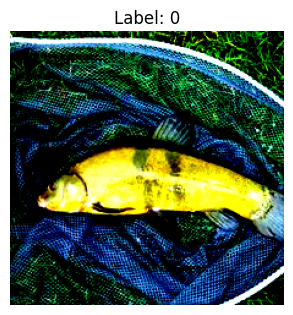

In [8]:
# Display the original image
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title(f"Label: {original_label}")
plt.axis('off')

# Save the perturbed image and the perturbation as image files
perturbed_image_numpy = perturbed_image.squeeze(0).cpu().numpy().squeeze().transpose((1, 2, 0))
perturbed_image_pil = Image.fromarray((perturbed_image_numpy * 255).astype(np.uint8))
perturbed_image_pil.save("perturbed_image.png")

perturbation_image = Image.fromarray((perturbation * 255).astype(np.uint8))
perturbation_image.save("perturbation_image.png")



# Open and display the perturbed image
perturbed_image = Image.open("perturbed_image.png")
plt.subplot(132)
plt.imshow(perturbed_image)
plt.title(f"Label: {perturbed_label}")
plt.axis('off')

# Open and display the perturbation
perturbation_image = Image.open("perturbation_image.png")
plt.subplot(133)
plt.imshow(perturbation_image)
plt.title("Perturbation")
plt.axis('off')

plt.show()

In [2]:
import torch

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [3]:
import matplotlib.pyplot as plt

def display_images_and_predictions(image1, image2, model):
    # Convert PyTorch tensors to NumPy arrays
    image1 = image1.detach().numpy()
    image2 = image2.detach().numpy()

    # Predict the classes of the images
    pred1 = model(image1)
    pred2 = model(image2)

    # Find the difference between the images
    diff_image = np.abs(image1 - image2)

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))

    # Display image1 and its prediction
    axs[0].imshow(image1.transpose((1, 2, 0)))
    axs[0].set_title(f'Prediction: {np.argmax(pred1)}')

    # Display image2 and its prediction
    axs[1].imshow(image2.transpose((1, 2, 0)))
    axs[1].set_title(f'Prediction: {np.argmax(pred2)}')

    # Display the difference image
    axs[2].imshow(diff_image.transpose((1, 2, 0)))
    axs[2].set_title('Difference')

    # Remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.models import alexnet
from PIL import Image

# Load the pre-trained AlexNet model
model = alexnet(pretrained=True)

# If you have a GPU, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an image from a file
image_path = 'C:\\Users\\josep\\OneDrive\\Desktop\\ML2_Project\\AdversarialRobustnessML\\DataFiles\\ImageNet\\Original\\imagenette2-320\\train\\n01440764\\ILSVRC2012_val_00007197.JPEG'
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)

# Move the image tensor to the same device as the model
image = image.to(device)

# Calculate the gradients for the image
image.requires_grad = True
output = model(image)
loss = output.max()
model.zero_grad()
loss.backward()
data_grad = image.grad.data

# Apply the FGSM attack
epsilon = 0.01  # You might need to adjust this value based on your specific use case
perturbed_image = fgsm_attack(image, epsilon, data_grad)

# Move tensors back to CPU for visualization
image = image.to('cpu')
perturbed_image = perturbed_image.to('cpu')

# Display the original and perturbed images and their predictions
display_images_and_predictions(image[0], perturbed_image[0], model)


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
